# GEI723 Université de Sherbrooke, Nov. 2020

# Etude des différentes formes de STDP

  Ce notebook met en relief quelques formes de la STDP, ainsi l'effet de la fréquence sur l'impact de la STDP et un moyen d'y remedier; Il est basé sur les notebook d'Ismaël Balafrej et Ahmad El Ferdaoussi sur la STDP et sur l’article de Diehl et Cook.

  Ce code a été réalisé par :
- ETTAHI Yahya (CIP:etty2601)
- WAHBI Yasmine (CIP:wahy3501)
- YARGA Arnaud (CIP:yars2201)

  Grands axes de ce notebook : 
- formes I et II de la STDP (excitatrice à excitatrice - excitatrice à inhibitrice)
- Effet de la fréquence sur les résultats
- l'homéostasie en service de la STDP

In [1]:
from brian2 import *
prefs.codegen.target = "numpy" # By using numpy, the simulation will be faster to simulate small networks
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline


Premièrement, nous avons essayé d'implémenter les différentes configurations de la STDP (forme I et forme II - excitatrice a excitatrice et excitatrice à inhibitrice ). Pour se faire, nous sommes appuyés sur le notebook d'Ismaël Balafrej et Ahmad El Ferdaoussi intitulé "L'effet des paramètres de la règle d'apprentissage STDP"

# Excitatrice à excitatrice forme I

Paramètres par WAHBI Yasmine

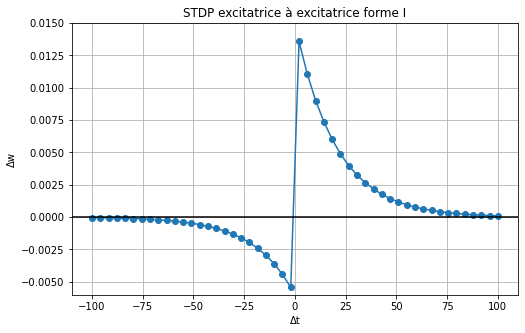

In [2]:
start_scope()

# Création des neurones
tau = 10*ms
eqs_neuron = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(2, model=eqs_neuron, threshold='v>1', reset='v=0', method='euler')

# Création des synapses
tau_a = tau_b = 20*ms
A = 0.015
B = -0.006

eqs_stdp = '''
    w : 1
    da/dt = -a / tau_a : 1 (event-driven) 
    db/dt = -b / tau_b : 1 (event-driven)
'''
on_pre = '''
    v_post += w
    a += A
    w = w + b
'''
on_post = '''
    b += B
    w = w + a
'''

S = Synapses(G, G, model=eqs_stdp, on_pre=on_pre, on_post=on_post, method='euler')

# Création d'une connexion synaptique
S.connect(i=0, j=1)

# Générons maintenant des entrées pour nos neurones
input_generator = SpikeGeneratorGroup(2, [], []*ms) # Our input layer consist of 2 neurons
# Connectons ce générateur à nos deux neurones
input_generator_synapses = Synapses(input_generator, G, on_pre='v_post += 2') # Forcer des décharges
input_generator_synapses.connect(i=[0, 1], j=[0, 1]) 

# Faisons la simulation pour différents Delta t et calculons Delta w.
deltat = np.linspace(-100, 100, num=50)
deltaw = np.zeros(deltat.size) # Vecteur pour les valeurs de Delta w

# On utilise store() et restore() pour faire cette simulation, comme expliqué dans le notebook sur Brian2!
store()

for i in range(deltat.size):
    dt = deltat[i]
    
    restore()
    
    # On fait en sorte que les neurones déchargent à 0 ms et à |dt| ms
    # En fonction du signe de dt, les neurones vont décharger un avant l'autre
    if dt < 0:
        input_generator.set_spikes([0, 1], [-dt, 0]*ms) 
    else:
        input_generator.set_spikes([0, 1], [0, dt]*ms)
    run((np.abs(dt)+1)*ms)
    deltaw[i] = S.w[0] # delta w est tout simplement w ici parce que w est à zéro initialement

# Faisons le graphique de dw en fonction de dt 
plt.figure(figsize=(8,5))
plt.plot(deltat, deltaw, linestyle='-', marker='o')
plt.title('STDP excitatrice à excitatrice forme I')
plt.xlabel('Δt')
plt.ylabel('Δw')
axhline(y=0, color='black')
plt.ylim(min(A, B), max(A, B))
plt.grid()

# Excitatrice à excitatrice forme II

Equations et paramètres par YARGA Arnaud

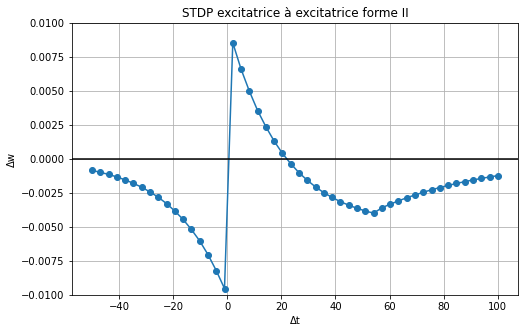

In [3]:
start_scope()

# Création des neurones
tau = 10*ms
eqs_neuron = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(2, model=eqs_neuron, threshold='v>1', reset='v=0', method='euler')

# Création des synapses
tau_a = tau_b = 20*ms
A = 0.01
B = -A

eqs_stdp = '''
    w : 1
    da1/dt = (-0.005-a1) / tau_a : 1 (event-driven) 
    da2/dt = (-a2) / (2*tau_a) : 1 (event-driven)
    db/dt = -b / tau_b : 1 (event-driven)
'''
on_pre = '''
    v_post += w
    a1 += A
    a2 += (-A-0.005)
    w = w + b
'''
on_post = '''
    b += B
    w = w + a1*int(a1>-0.004)+a2*int(a1<=-0.004)
'''


S = Synapses(G, G, model=eqs_stdp, on_pre=on_pre, on_post=on_post, method='euler')

# Création d'une connexion synaptique
S.connect(i=0, j=1)

# Générons maintenant des entrées pour nos neurones
input_generator = SpikeGeneratorGroup(2, [], []*ms) # Our input layer consist of 2 neurons
# Connectons ce générateur à nos deux neurones
input_generator_synapses = Synapses(input_generator, G, on_pre='v_post += 2') # Forcer des décharges
input_generator_synapses.connect(i=[0, 1], j=[0, 1]) 

# Faisons la simulation pour différents Delta t et calculons Delta w.
deltat = np.linspace(-50, 100, num=50)
deltaw = np.zeros(deltat.size) # Vecteur pour les valeurs de Delta w

# On utilise store() et restore() pour faire cette simulation, comme expliqué dans le notebook sur Brian2!
store()

for i in range(deltat.size):
    dt = deltat[i]
    
    restore()
    
    # On fait en sorte que les neurones déchargent à 0 ms et à |dt| ms
    # En fonction du signe de dt, les neurones vont décharger un avant l'autre
    if dt < 0:
        input_generator.set_spikes([0, 1], [-dt, 0]*ms) 
    else:
        input_generator.set_spikes([0, 1], [0, dt]*ms)
    run((np.abs(dt)+1)*ms)
    deltaw[i] = S.w[0] # delta w est tout simplement w ici parce que w est à zéro initialement

# Faisons le graphique de dw en fonction de dt 
plt.figure(figsize=(8,5))
plt.plot(deltat, deltaw, linestyle='-', marker='o')
plt.title('STDP excitatrice à excitatrice forme II')
plt.xlabel('Δt')
plt.ylabel('Δw')
axhline(y=0, color='black')
plt.ylim(min(A, B), max(A, B))
plt.grid()

# Excitatrice à inhibitrice forme I

Equations et paramètres par WAHBI Yasmine

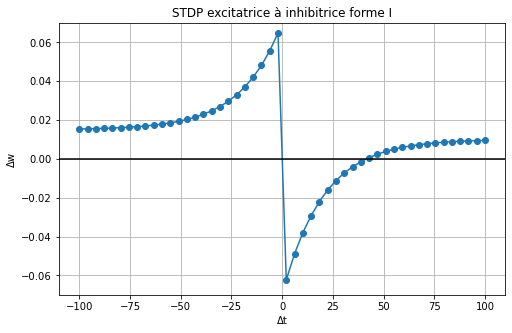

In [4]:
start_scope()

# Création des neurones
tau = 10*ms
eqs_neuron = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(2, model=eqs_neuron, threshold='v>1', reset='v=0', method='euler')

# Création des synapses
tau_a = tau_b = 20*ms
A = -0.07
B = 0.07

eqs_stdp = '''
    w : 1
    da/dt = (-a + 0.01) / tau_a : 1 (event-driven) 
    db/dt = (-b + 0.015) / tau_b : 1 (event-driven)
'''
on_pre = '''
    v_post += w
    a += A
    w = w + b
'''
on_post = '''
    b += B
    w = w + a
'''

S = Synapses(G, G, model=eqs_stdp, on_pre=on_pre, on_post=on_post, method='euler')

# Création d'une connexion synaptique
S.connect(i=0, j=1)

# Générons maintenant des entrées pour nos neurones
input_generator = SpikeGeneratorGroup(2, [], []*ms) # Our input layer consist of 2 neurons
# Connectons ce générateur à nos deux neurones
input_generator_synapses = Synapses(input_generator, G, on_pre='v_post += 2') # Forcer des décharges
input_generator_synapses.connect(i=[0, 1], j=[0, 1]) 

# Faisons la simulation pour différents Delta t et calculons Delta w.
deltat = np.linspace(-100, 100, num=50)
deltaw = np.zeros(deltat.size) # Vecteur pour les valeurs de Delta w

# On utilise store() et restore() pour faire cette simulation, comme expliqué dans le notebook sur Brian2!
store()

for i in range(deltat.size):
    dt = deltat[i]
    
    restore()
    
    # On fait en sorte que les neurones déchargent à 0 ms et à |dt| ms
    # En fonction du signe de dt, les neurones vont décharger un avant l'autre
    if dt < 0:
        input_generator.set_spikes([0, 1], [-dt, 0]*ms) 
    else:
        input_generator.set_spikes([0, 1], [0, dt]*ms)
    run((np.abs(dt)+1)*ms)
    deltaw[i] = S.w[0] # delta w est tout simplement w ici parce que w est à zéro initialement

# Faisons le graphique de dw en fonction de dt 
plt.figure(figsize=(8,5))
plt.plot(deltat, deltaw, linestyle='-', marker='o')
plt.title('STDP excitatrice à inhibitrice forme I')
plt.xlabel('Δt')
plt.ylabel('Δw')
axhline(y=0, color='black')
plt.ylim(min(A, B), max(A, B))
plt.grid()

# Excitateur à inhibiteur forme II

Equations et paramètres par ETTAHI Yahya

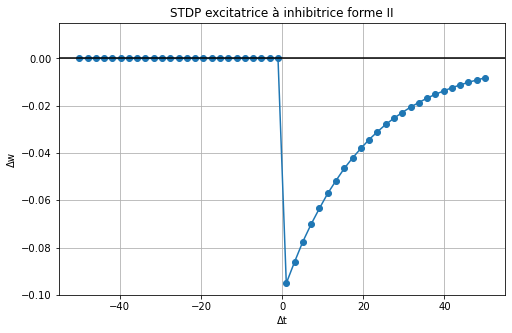

In [5]:
start_scope()

# Création des neurones
tau = 10*ms
eqs_neuron = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(2, model=eqs_neuron, threshold='v>1', reset='v=0', method='euler')

# Création des synapses
tau_a = tau_b = 20*ms
A = -0.1
B = 0.015

eqs_stdp = '''
    w : 1
    da/dt = -a / tau_a : 1 (event-driven) 
    db/dt = -b / tau_b : 1 (event-driven)
'''
on_pre = '''
    v_post += w
    a += A
    w = 0
'''
on_post = '''
    b += B
    w = w + a
'''

S = Synapses(G, G, model=eqs_stdp, on_pre=on_pre, on_post=on_post, method='euler')

# Création d'une connexion synaptique
S.connect(i=0, j=1)

# Générons maintenant des entrées pour nos neurones
input_generator = SpikeGeneratorGroup(2, [], []*ms) # Our input layer consist of 2 neurons
# Connectons ce générateur à nos deux neurones
input_generator_synapses = Synapses(input_generator, G, on_pre='v_post += 2') # Forcer des décharges
input_generator_synapses.connect(i=[0, 1], j=[0, 1]) 

# Faisons la simulation pour différents Delta t et calculons Delta w.
deltat = np.linspace(-50, 50, num=50)
deltaw = np.zeros(deltat.size) # Vecteur pour les valeurs de Delta w

# On utilise store() et restore() pour faire cette simulation, comme expliqué dans le notebook sur Brian2!
store()

for i in range(deltat.size):
    dt = deltat[i]
    
    restore()
    
    # On fait en sorte que les neurones déchargent à 0 ms et à |dt| ms
    # En fonction du signe de dt, les neurones vont décharger un avant l'autre
    if dt < 0:
        input_generator.set_spikes([0, 1], [-dt, 0]*ms) 
    else:
        input_generator.set_spikes([0, 1], [0, dt]*ms)
    run((np.abs(dt)+1)*ms)
    deltaw[i] = S.w[0] # delta w est tout simplement w ici parce que w est à zéro initialement

# Faisons le graphique de dw en fonction de dt 
plt.figure(figsize=(8,5))
plt.plot(deltat, deltaw, linestyle='-', marker='o')
plt.title('STDP excitatrice à inhibitrice forme II')
plt.xlabel('Δt')
plt.ylabel('Δw')
axhline(y=0, color='black')
plt.ylim(min(A, B), max(A, B))
plt.grid()

# Effet de la fréquence : 

Ensuite, pour visionner l'effet de la fréquence, nous avons utilisé l'exemple fourni sur Brian2 :  https://brian2.readthedocs.io/en/latest/examples/synapses.STDP.html

Adaptation des équations et paramètres par WAHBI Yasmine

En premier temps, nous avons commencer par la première forme de la STDP "la classique" et donc au niveau du code nous avons se contenter juste de modifier la valeur de la fréquence puis visionner la différence pour pouvoir comparer et interpréter l'effet du changement de la fréquence.

Pour une fréquence qui vaut 15 Hz

WARNING    "dt" is an internal variable of group "poissongroup_2", but also exists in the run namespace with the value 50.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 100. s
3.0514 s (3%) simulated in 10s, estimated 5m 18s remaining.
6.194 s (6%) simulated in 20s, estimated 5m 3s remaining.
8.6791 s (8%) simulated in 30s, estimated 5m 16s remaining.
11.3861 s (11%) simulated in 40s, estimated 5m 12s remaining.
14.172 s (14%) simulated in 50s, estimated 5m 3s remaining.
16.3022 s (16%) simulated in 1m 0s, estimated 5m 8s remaining.
18.453 s (18%) simulated in 1m 10s, estimated 5m 9s remaining.
20.5341 s (20%) simulated in 1m 20s, estimated 5m 10s remaining.
22.5538 s (22%) simulated in 1m 30s, estimated 5m 9s remaining.
24.6499 s (24%) simulated in 1m 40s, estimated 5m 6s remaining.
27.1057 s (27%) simulated in 1m 50s, estimated 4m 56s remaining.
29.7283 s (29%) simulated in 2m 0s, estimated 4m 44s remaining.
32.392 s (32%) simulated in 2m 10s, estimated 4m 31s remaining.
35.168 s (35%) simulated in 2m 20s, estimated 4m 18s remaining.
37.9551 s (37%) simulated in 2m 30s, estimated 4m 5s remaining.
40.67

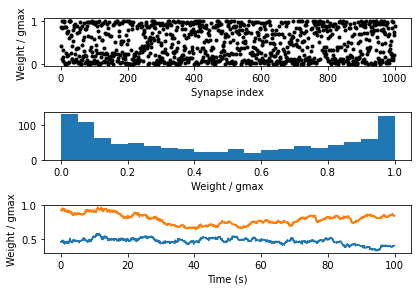

In [8]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr', method='euler')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Pour une fréquence qui vaut 6 Hz

Starting simulation at t=0. s for a duration of 100. s
3.3234 s (3%) simulated in 10s, estimated 4m 51s remaining.
5.7734 s (5%) simulated in 20s, estimated 5m 27s remaining.
9.0325 s (9%) simulated in 30s, estimated 5m 3s remaining.
11.8428 s (11%) simulated in 40s, estimated 4m 58s remaining.
14.6216 s (14%) simulated in 50s, estimated 4m 52s remaining.
17.6355 s (17%) simulated in 1m 0s, estimated 4m 40s remaining.
20.4522 s (20%) simulated in 1m 10s, estimated 4m 32s remaining.
23.4305 s (23%) simulated in 1m 20s, estimated 4m 22s remaining.
26.1084 s (26%) simulated in 1m 30s, estimated 4m 15s remaining.
29.5941 s (29%) simulated in 1m 40s, estimated 3m 58s remaining.
33.2722 s (33%) simulated in 1m 50s, estimated 3m 41s remaining.
36.9124 s (36%) simulated in 2m 0s, estimated 3m 25s remaining.
40.6095 s (40%) simulated in 2m 10s, estimated 3m 10s remaining.
43.9066 s (43%) simulated in 2m 20s, estimated 2m 59s remaining.
47.5521 s (47%) simulated in 2m 30s, estimated 2m 46s remai

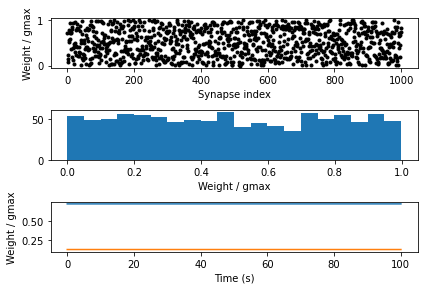

In [9]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 6*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Pour une fréquence qui vaut 10 Hz

Starting simulation at t=0. s for a duration of 100. s
2.9221 s (2%) simulated in 10s, estimated 5m 32s remaining.
6.3584 s (6%) simulated in 20s, estimated 4m 55s remaining.
9.8005 s (9%) simulated in 30s, estimated 4m 36s remaining.
13.2947 s (13%) simulated in 40s, estimated 4m 21s remaining.
16.7704 s (16%) simulated in 50s, estimated 4m 8s remaining.
20.245 s (20%) simulated in 1m 0s, estimated 3m 56s remaining.
23.6775 s (23%) simulated in 1m 10s, estimated 3m 46s remaining.
27.1361 s (27%) simulated in 1m 20s, estimated 3m 35s remaining.
30.6159 s (30%) simulated in 1m 30s, estimated 3m 24s remaining.
34.0946 s (34%) simulated in 1m 40s, estimated 3m 13s remaining.
37.5783 s (37%) simulated in 1m 50s, estimated 3m 3s remaining.
41.0486 s (41%) simulated in 2m 0s, estimated 2m 52s remaining.
44.5165 s (44%) simulated in 2m 10s, estimated 2m 42s remaining.
47.9853 s (47%) simulated in 2m 20s, estimated 2m 32s remaining.
51.4423 s (51%) simulated in 2m 30s, estimated 2m 22s remaini

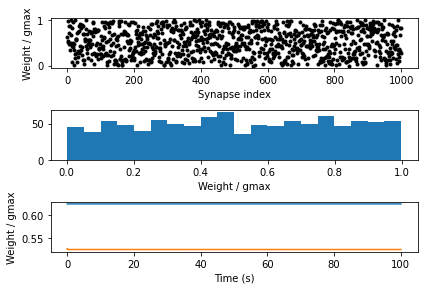

In [10]:
N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 10*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Pour pouvoir trouver la valeur exacte à partir de laquelle la transition se fait c'est à dire à partir de laquelle la STDP commence à avoir un effet comme le cas pour F = 15 Hz, nous avons essayé avec plusieurs valeurs de fréquences comprises entre 10 et 15 Hz. Ainsi, nous avons pu relevé qu'à partir d'une valeur entre 12 et 13 Hz la transition commence ceci.

Dans ce qui suit, on passe à la forme II de la STDP excitatrice vers excitatrice; 

Et donc pour F = 15 Hz

Starting simulation at t=0. s for a duration of 100. s
3.0633 s (3%) simulated in 10s, estimated 5m 16s remaining.
6.4763 s (6%) simulated in 20s, estimated 4m 49s remaining.
9.8971 s (9%) simulated in 30s, estimated 4m 33s remaining.
13.3372 s (13%) simulated in 40s, estimated 4m 20s remaining.
16.7594 s (16%) simulated in 50s, estimated 4m 8s remaining.
20.2138 s (20%) simulated in 1m 0s, estimated 3m 57s remaining.
23.5322 s (23%) simulated in 1m 10s, estimated 3m 47s remaining.
26.952 s (26%) simulated in 1m 20s, estimated 3m 37s remaining.
30.3491 s (30%) simulated in 1m 30s, estimated 3m 27s remaining.
33.7418 s (33%) simulated in 1m 40s, estimated 3m 16s remaining.
37.1888 s (37%) simulated in 1m 50s, estimated 3m 6s remaining.
40.6074 s (40%) simulated in 2m 0s, estimated 2m 56s remaining.
43.9753 s (43%) simulated in 2m 10s, estimated 2m 46s remaining.
47.4481 s (47%) simulated in 2m 20s, estimated 2m 35s remaining.
50.8648 s (50%) simulated in 2m 30s, estimated 2m 25s remaini

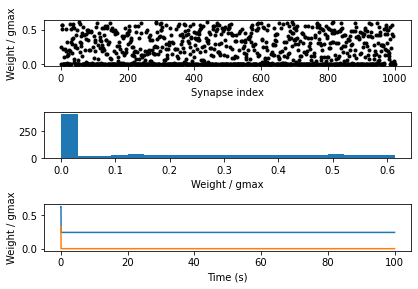

In [4]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre1 = .01
dApre2 = -dApre1-0.005
dApost = -dApre1 * taupre / taupost * 1.05
dApost *= gmax
dApre1 *= gmax
dApre2 *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
                '''w : 1
                dApre1/dt = (-0.005-Apre1)/ taupre : 1 (event-driven)
                dApre2/dt = -Apre2/ (2*taupre) : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre1 += dApre1
                    Apre2 += dApre2
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre1*int(Apre1>-0.004) + Apre2*int(Apre1<=-0.004), 0, gmax)''',     
            )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Pour F = 6 Hz

Starting simulation at t=0. s for a duration of 100. s
4.0462 s (4%) simulated in 10s, estimated 3m 57s remaining.
8.0621 s (8%) simulated in 20s, estimated 3m 48s remaining.
11.7602 s (11%) simulated in 30s, estimated 3m 45s remaining.
15.9594 s (15%) simulated in 40s, estimated 3m 31s remaining.
20.258 s (20%) simulated in 50s, estimated 3m 17s remaining.
24.5605 s (24%) simulated in 1m 0s, estimated 3m 4s remaining.
28.8915 s (28%) simulated in 1m 10s, estimated 2m 52s remaining.
32.9944 s (32%) simulated in 1m 20s, estimated 2m 42s remaining.
36.6227 s (36%) simulated in 1m 30s, estimated 2m 36s remaining.
40.9876 s (40%) simulated in 1m 40s, estimated 2m 24s remaining.
45.3179 s (45%) simulated in 1m 50s, estimated 2m 13s remaining.
49.5439 s (49%) simulated in 2m 0s, estimated 2m 2s remaining.
53.8836 s (53%) simulated in 2m 10s, estimated 1m 51s remaining.
58.2535 s (58%) simulated in 2m 20s, estimated 1m 40s remaining.
62.7045 s (62%) simulated in 2m 30s, estimated 1m 29s remai

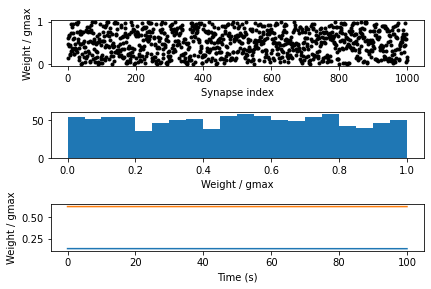

In [5]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 6*Hz
gmax = .01
dApre1 = .01
dApre2 = -dApre1-0.005
dApost = -dApre1 * taupre / taupost * 1.05
dApost *= gmax
dApre1 *= gmax
dApre2 *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
                '''w : 1
                dApre1/dt = (-0.005-Apre1)/ taupre : 1 (event-driven)
                dApre2/dt = -Apre2/ (2*taupre) : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre1 += dApre1
                    Apre2 += dApre2
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre1*int(Apre1>-0.004) + Apre2*int(Apre1<=-0.004), 0, gmax)''',     
            )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Pour F = 10 Hz

Starting simulation at t=0. s for a duration of 100. s
3.762 s (3%) simulated in 10s, estimated 4m 16s remaining.
7.5798 s (7%) simulated in 20s, estimated 4m 4s remaining.
11.3878 s (11%) simulated in 30s, estimated 3m 53s remaining.
15.1949 s (15%) simulated in 40s, estimated 3m 43s remaining.
18.981 s (18%) simulated in 50s, estimated 3m 33s remaining.
22.8086 s (22%) simulated in 1m 0s, estimated 3m 23s remaining.
26.5823 s (26%) simulated in 1m 10s, estimated 3m 13s remaining.
30.0909 s (30%) simulated in 1m 20s, estimated 3m 6s remaining.
33.5699 s (33%) simulated in 1m 30s, estimated 2m 58s remaining.
37.4047 s (37%) simulated in 1m 40s, estimated 2m 47s remaining.
41.2448 s (41%) simulated in 1m 50s, estimated 2m 37s remaining.
45.0728 s (45%) simulated in 2m 0s, estimated 2m 26s remaining.
48.8896 s (48%) simulated in 2m 10s, estimated 2m 16s remaining.
52.7069 s (52%) simulated in 2m 20s, estimated 2m 6s remaining.
56.5872 s (56%) simulated in 2m 30s, estimated 1m 55s remaini

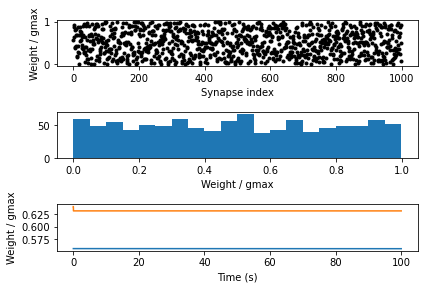

In [6]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 10*Hz
gmax = .01
dApre1 = .01
dApre2 = -dApre1-0.005
dApost = -dApre1 * taupre / taupost * 1.05
dApost *= gmax
dApre1 *= gmax
dApre2 *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
                '''w : 1
                dApre1/dt = (-0.005-Apre1)/ taupre : 1 (event-driven)
                dApre2/dt = -Apre2/ (2*taupre) : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre1 += dApre1
                    Apre2 += dApre2
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre1*int(Apre1>-0.004) + Apre2*int(Apre1<=-0.004), 0, gmax)''',     
            )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Dans cette partie, on met l'accent sur la forme I de la STDP excitatrice vers inhibitrice.

Alors pour F = 15 Hz

Starting simulation at t=0. s for a duration of 100. s
2.5705 s (2%) simulated in 10s, estimated 6m 19s remaining.
4.9281 s (4%) simulated in 20s, estimated 6m 26s remaining.
6.9443 s (6%) simulated in 30s, estimated 6m 42s remaining.
9.2286 s (9%) simulated in 40s, estimated 6m 34s remaining.
11.4955 s (11%) simulated in 50s, estimated 6m 25s remaining.
13.8575 s (13%) simulated in 1m 0s, estimated 6m 13s remaining.
15.5164 s (15%) simulated in 1m 10s, estimated 6m 21s remaining.
17.2903 s (17%) simulated in 1m 20s, estimated 6m 23s remaining.
19.582 s (19%) simulated in 1m 30s, estimated 6m 10s remaining.
21.9494 s (21%) simulated in 1m 40s, estimated 5m 56s remaining.
24.0989 s (24%) simulated in 1m 50s, estimated 5m 47s remaining.
26.45 s (26%) simulated in 2m 0s, estimated 5m 34s remaining.
28.9089 s (28%) simulated in 2m 10s, estimated 5m 20s remaining.
31.3085 s (31%) simulated in 2m 20s, estimated 5m 7s remaining.
33.9519 s (33%) simulated in 2m 30s, estimated 4m 52s remaining.

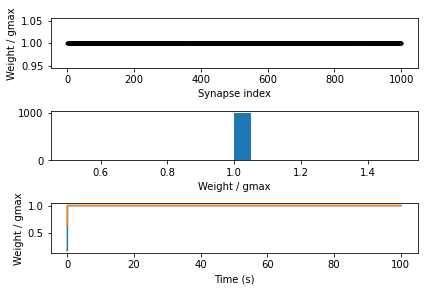

In [14]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax


eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = (-Apre + 0.01) / taupre : 1 (event-driven)
                dApost/dt = (-Apost + 0.015) / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )

S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Pour F = 6 Hz

Starting simulation at t=0. s for a duration of 100. s
3.7202 s (3%) simulated in 10s, estimated 4m 19s remaining.
7.4444 s (7%) simulated in 20s, estimated 4m 9s remaining.
11.121 s (11%) simulated in 30s, estimated 4m 0s remaining.
14.0072 s (14%) simulated in 40s, estimated 4m 6s remaining.
17.1898 s (17%) simulated in 50s, estimated 4m 1s remaining.
20.4552 s (20%) simulated in 1m 0s, estimated 3m 53s remaining.
23.9634 s (23%) simulated in 1m 10s, estimated 3m 42s remaining.
27.5203 s (27%) simulated in 1m 20s, estimated 3m 31s remaining.
31.0339 s (31%) simulated in 1m 30s, estimated 3m 20s remaining.
34.6152 s (34%) simulated in 1m 40s, estimated 3m 9s remaining.
38.192 s (38%) simulated in 1m 50s, estimated 2m 58s remaining.
41.7653 s (41%) simulated in 2m 0s, estimated 2m 47s remaining.
45.3549 s (45%) simulated in 2m 10s, estimated 2m 37s remaining.
48.937 s (48%) simulated in 2m 20s, estimated 2m 26s remaining.
52.4926 s (52%) simulated in 2m 30s, estimated 2m 16s remaining.

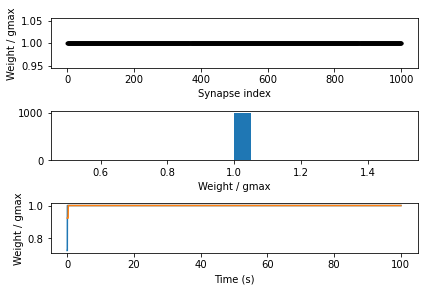

In [15]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 6*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax


eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = (-Apre + 0.01) / taupre : 1 (event-driven)
                dApost/dt = (-Apost + 0.015) / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )

S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Pour F = 10 Hz

Starting simulation at t=0. s for a duration of 100. s
2.9344 s (2%) simulated in 10s, estimated 5m 31s remaining.
5.6003 s (5%) simulated in 20s, estimated 5m 37s remaining.
8.5743 s (8%) simulated in 30s, estimated 5m 20s remaining.
11.3288 s (11%) simulated in 40s, estimated 5m 13s remaining.
13.4053 s (13%) simulated in 50s, estimated 5m 23s remaining.
16.231 s (16%) simulated in 1m 0s, estimated 5m 10s remaining.
19.2213 s (19%) simulated in 1m 10s, estimated 4m 54s remaining.
22.4675 s (22%) simulated in 1m 20s, estimated 4m 36s remaining.
25.696 s (25%) simulated in 1m 30s, estimated 4m 20s remaining.
28.9336 s (28%) simulated in 1m 40s, estimated 4m 6s remaining.
32.1858 s (32%) simulated in 1m 50s, estimated 3m 52s remaining.
35.4306 s (35%) simulated in 2m 0s, estimated 3m 39s remaining.
38.6841 s (38%) simulated in 2m 10s, estimated 3m 26s remaining.
41.9496 s (41%) simulated in 2m 20s, estimated 3m 14s remaining.
45.2062 s (45%) simulated in 2m 30s, estimated 3m 2s remainin

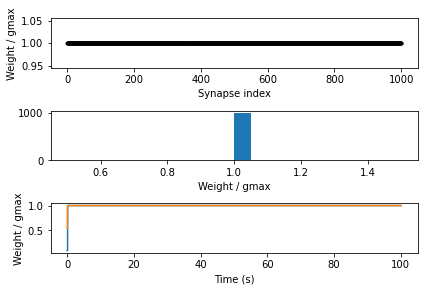

In [16]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 10*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax


eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = (-Apre + 0.01) / taupre : 1 (event-driven)
                dApost/dt = (-Apost + 0.015) / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )

S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Finalement, pour la dernière forme restante : la forme II de la STDP excitatrice vers inhibitrice.

On effetue aussi les mêmes expériences; commencons par F = 15 Hz

Starting simulation at t=0. s for a duration of 100. s
3.6056 s (3%) simulated in 10s, estimated 4m 28s remaining.
7.2211 s (7%) simulated in 20s, estimated 4m 17s remaining.
10.8429 s (10%) simulated in 30s, estimated 4m 7s remaining.
14.4719 s (14%) simulated in 40s, estimated 3m 57s remaining.
18.1002 s (18%) simulated in 50s, estimated 3m 46s remaining.
21.74 s (21%) simulated in 1m 0s, estimated 3m 36s remaining.
25.3697 s (25%) simulated in 1m 10s, estimated 3m 26s remaining.
28.9881 s (28%) simulated in 1m 20s, estimated 3m 16s remaining.
32.5845 s (32%) simulated in 1m 30s, estimated 3m 6s remaining.
36.2036 s (36%) simulated in 1m 40s, estimated 2m 56s remaining.
39.8286 s (39%) simulated in 1m 50s, estimated 2m 46s remaining.
43.4637 s (43%) simulated in 2m 0s, estimated 2m 36s remaining.
46.7806 s (46%) simulated in 2m 10s, estimated 2m 28s remaining.
50.3036 s (50%) simulated in 2m 20s, estimated 2m 18s remaining.
53.8498 s (53%) simulated in 2m 30s, estimated 2m 9s remaini

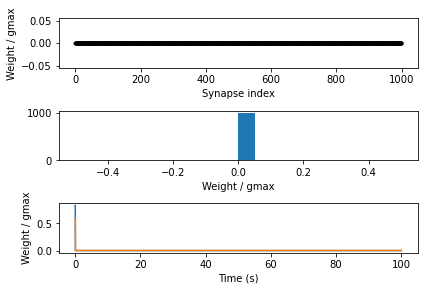

In [17]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax


eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = 0''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )

S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Pour F = 6 Hz

Starting simulation at t=0. s for a duration of 100. s
3.6722 s (3%) simulated in 10s, estimated 4m 22s remaining.
7.8312 s (7%) simulated in 20s, estimated 3m 56s remaining.
12.0465 s (12%) simulated in 30s, estimated 3m 39s remaining.
15.9899 s (15%) simulated in 40s, estimated 3m 30s remaining.
20.2288 s (20%) simulated in 50s, estimated 3m 17s remaining.
24.4042 s (24%) simulated in 1m 0s, estimated 3m 6s remaining.
27.9987 s (27%) simulated in 1m 10s, estimated 3m 0s remaining.
32.0926 s (32%) simulated in 1m 20s, estimated 2m 49s remaining.
35.7514 s (35%) simulated in 1m 30s, estimated 2m 42s remaining.
39.3043 s (39%) simulated in 1m 40s, estimated 2m 35s remaining.
42.7395 s (42%) simulated in 1m 50s, estimated 2m 27s remaining.
46.288 s (46%) simulated in 2m 0s, estimated 2m 19s remaining.
49.5799 s (49%) simulated in 2m 10s, estimated 2m 12s remaining.
52.7479 s (52%) simulated in 2m 20s, estimated 2m 5s remaining.
56.295 s (56%) simulated in 2m 30s, estimated 1m 57s remaini

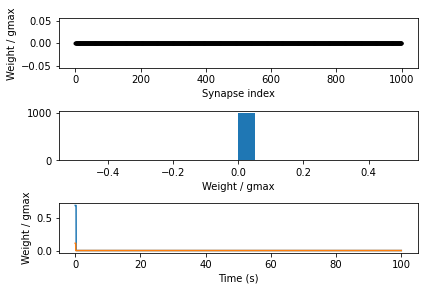

In [18]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 6*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax


eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = 0''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )

S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Pour F = 10 Hz

Starting simulation at t=0. s for a duration of 100. s
3.4064 s (3%) simulated in 10s, estimated 4m 44s remaining.
6.6754 s (6%) simulated in 20s, estimated 4m 40s remaining.
10.0485 s (10%) simulated in 30s, estimated 4m 29s remaining.
13.0831 s (13%) simulated in 40s, estimated 4m 26s remaining.
15.8955 s (15%) simulated in 50s, estimated 4m 25s remaining.
19.2559 s (19%) simulated in 1m 0s, estimated 4m 12s remaining.
22.5541 s (22%) simulated in 1m 10s, estimated 4m 0s remaining.
25.4818 s (25%) simulated in 1m 20s, estimated 3m 54s remaining.
28.8683 s (28%) simulated in 1m 30s, estimated 3m 42s remaining.
32.278 s (32%) simulated in 1m 40s, estimated 3m 30s remaining.
35.8204 s (35%) simulated in 1m 50s, estimated 3m 17s remaining.
39.0814 s (39%) simulated in 2m 0s, estimated 3m 7s remaining.
42.4162 s (42%) simulated in 2m 10s, estimated 2m 57s remaining.
46.2929 s (46%) simulated in 2m 20s, estimated 2m 42s remaining.
50.1564 s (50%) simulated in 2m 30s, estimated 2m 29s remai

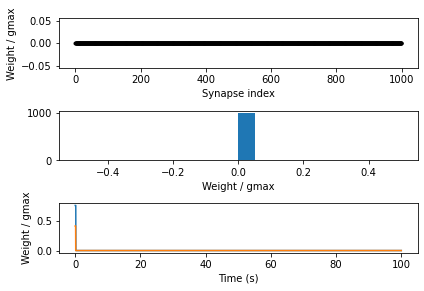

In [19]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 10*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax


eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = 0''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )

S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

# L'homéostasie en service de la STDP :

Afin de pouvoir modifier la STDP pour faire en sorte qu’elle soit le moins possible sensible aux changements de fréquences dans le réseau, nous avons proposé d'introduire l'homéostasie. Ceci nous a permis de voir une modification de poids entre les valeurs initiales et ceux finaux pour les basses fréquences. 

Nous avons essayé de réaliser cette expérience sur la forme classique de STDP.

Proposé par YARGA Arnaud et ETTAHI Yahya, Implémenté par WAHBI Yasmine

Et donc pour F = 6 Hz

Starting simulation at t=0. s for a duration of 100. s
3.4784 s (3%) simulated in 10s, estimated 4m 38s remaining.
6.7343 s (6%) simulated in 20s, estimated 4m 37s remaining.
9.9073 s (9%) simulated in 30s, estimated 4m 33s remaining.
13.3868 s (13%) simulated in 40s, estimated 4m 19s remaining.
16.3252 s (16%) simulated in 50s, estimated 4m 16s remaining.
19.0932 s (19%) simulated in 1m 0s, estimated 4m 14s remaining.
22.5791 s (22%) simulated in 1m 10s, estimated 4m 0s remaining.
26.1566 s (26%) simulated in 1m 20s, estimated 3m 46s remaining.
29.7303 s (29%) simulated in 1m 30s, estimated 3m 33s remaining.
33.2945 s (33%) simulated in 1m 40s, estimated 3m 20s remaining.
36.8445 s (36%) simulated in 1m 50s, estimated 3m 9s remaining.
40.4241 s (40%) simulated in 2m 0s, estimated 2m 57s remaining.
43.9777 s (43%) simulated in 2m 10s, estimated 2m 46s remaining.
47.5506 s (47%) simulated in 2m 20s, estimated 2m 35s remaining.
51.1239 s (51%) simulated in 2m 30s, estimated 2m 23s remain

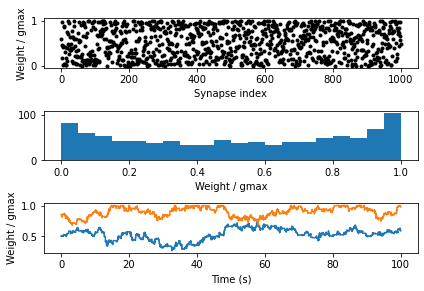

In [20]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 6*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax
tc_theta = 25*ms

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
dtheta/dt = (-theta-10*mV) / (tc_theta)  : volt
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>(vt + theta)', reset='v = vr; theta += 1*mV', method='euler')

S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()

Et pour F = 10 Hz

Starting simulation at t=0. s for a duration of 100. s
3.0506 s (3%) simulated in 10s, estimated 5m 18s remaining.
6.2127 s (6%) simulated in 20s, estimated 5m 2s remaining.
9.4207 s (9%) simulated in 30s, estimated 4m 49s remaining.
12.6221 s (12%) simulated in 40s, estimated 4m 37s remaining.
15.8012 s (15%) simulated in 50s, estimated 4m 27s remaining.
18.9674 s (18%) simulated in 1m 0s, estimated 4m 16s remaining.
21.8105 s (21%) simulated in 1m 10s, estimated 4m 11s remaining.
24.4086 s (24%) simulated in 1m 20s, estimated 4m 8s remaining.
26.171 s (26%) simulated in 1m 30s, estimated 4m 14s remaining.
28.3917 s (28%) simulated in 1m 40s, estimated 4m 12s remaining.
30.7685 s (30%) simulated in 1m 50s, estimated 4m 8s remaining.
33.3374 s (33%) simulated in 2m 0s, estimated 4m 0s remaining.
35.6027 s (35%) simulated in 2m 10s, estimated 3m 55s remaining.
37.3241 s (37%) simulated in 2m 20s, estimated 3m 55s remaining.
39.6686 s (39%) simulated in 2m 30s, estimated 3m 48s remaining

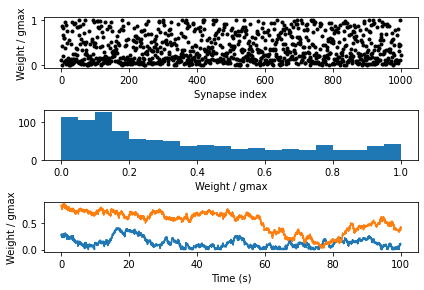

In [21]:
start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 10*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax
tc_theta = 25*ms

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
dtheta/dt = (-theta-10*mV) / (tc_theta)  : volt
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>(vt + theta)', reset='v = vr; theta += 1*mV', method='euler')

S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()